# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [1]:
import os
import sys
import random
from time import time
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")


#verificamos el path
sys.path

ModuleNotFoundError: No module named 'mrcnn'

## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Create Model and Load Trained Weights

In [4]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [38]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'Modelo', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'Hoja', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

## Run Object Detection

Processing 1 images
image                    shape: (1416, 1062, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1416.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


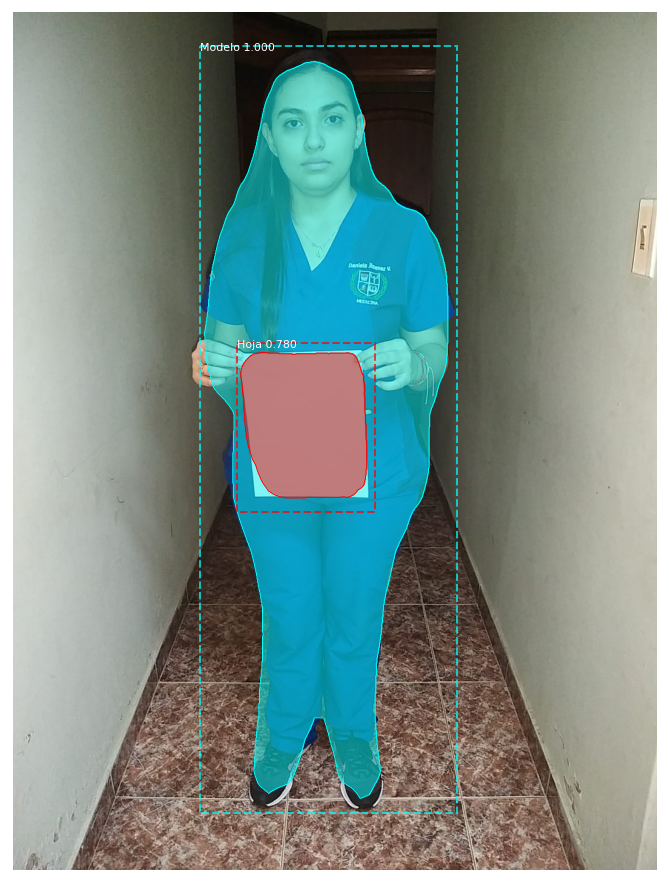

Tiempo de ejecución: 3.54 segundos


In [105]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
#image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
image = skimage.io.imread('daniela4.jpeg')
#Daniela: 160 cm
#Medición de tiempo
inicio=time()

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

print("Tiempo de ejecución: %.2f segundos"%(time()-inicio))

<class 'numpy.ndarray'>


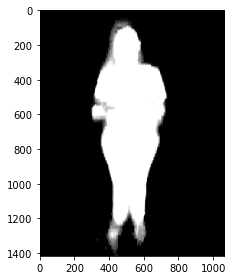

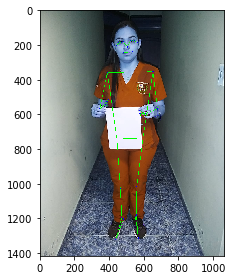

<class 'numpy.ndarray'>


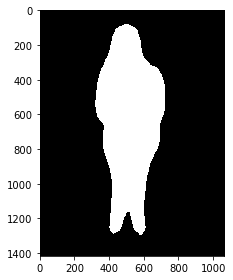

<class 'numpy.ndarray'>


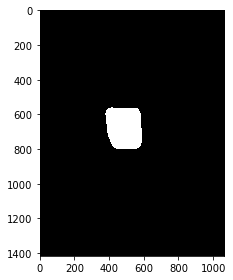

In [106]:

###OJO ALERTAR QUE NO SE DETECTÓ LA HOJA

#Se importan los paquetes necesarios para visualizar las máscaras de manera independiente
import cv2
import matplotlib.image as mpimg
import mediapipe as mp

mp_segmentation=mp.solutions.selfie_segmentation
mp_drawing=mp.solutions.drawing_utils
mp_pose=mp.solutions.pose

image_rgb=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

image_copy=image_rgb.copy()
segmentation_mask=None

with mp_segmentation.SelfieSegmentation(model_selection=1) as selfie_segmentation:
    result=selfie_segmentation.process(image_rgb)

    print(type(result.segmentation_mask))
    segmentation_mask=result.segmentation_mask.copy()
    skimage.io.imshow(result.segmentation_mask)
    plt.show()
    
with mp_pose.Pose(static_image_mode=True) as pose:
    result=pose.process(image_rgb)
    
    if result.pose_landmarks is not None:
        mp_drawing.draw_landmarks(image_rgb,result.pose_landmarks,mp_pose.POSE_CONNECTIONS)
        
        
    skimage.io.imshow(image_rgb)
    plt.show()
    
    
#Se identifica la cantidad de mascaras según la segmentación semántica
N = r['rois'].shape[0]

#se recorre cada mascara
for i in range(N):
    #Se transforma la mascasa de booleano a entero para posibilitar la impresión de la imagen
    #r['masks'][:,:,i].astype(int)
    
    print(type(r['masks'][:,:,i]))
    #Se imprime cada máscara generada
    skimage.io.imshow(r['masks'][:,:,i])
    plt.show()
    #plt.imshow(r['masks'][:,:,0])



In [107]:

hoja = r['masks'][:,:,1].astype(np.uint8)  #convert to an unsigned byte
hoja*=255

#modelo = segmentation_mask.astype(np.uint8) 
modelo = r['masks'][:,:,0].astype(np.uint8)  #convert to an unsigned byte
modelo*=255


indicesModelo = np.where(modelo == 255)
indicesHoja = np.where(hoja == 255)

print("Datos Hoja")
print("---------------")
print("Alto1: ",np.amin(indicesHoja[0]))
print("Alto2: ",np.amax(indicesHoja[0]))
print()
print("Ancho1: ",np.amin(indicesHoja[1]))
print("Ancho2: ",np.amax(indicesHoja[1]))
print()
print()
print("Datos Modelo")
print("---------------")
print("Alto1: ",np.amin(indicesModelo[0]))
#print(len(indicesModelo[0]))
print("Alto2: ",np.amax(indicesModelo[0]))
print()

hojaX1=np.amin(indicesHoja[0])
hojaX2=np.amax(indicesHoja[0])

hojaY1=np.amin(indicesHoja[1])
hojaY2=np.amax(indicesHoja[1])

modeloX1=np.amin(indicesModelo[0])
modeloX2=np.amax(indicesModelo[0])

tamañoHojaPxAncho=hojaY2-hojaY1
tamañoHojaCmAncho=21.6

tamañoHojaPx=hojaX2-hojaX1
tamañoHojaCm=28

tamañoModeloPx=modeloX2-modeloX1
tamañoModeloCm=((tamañoModeloPx*tamañoHojaCm)/tamañoHojaPx)

tamañoModeloCm2=((tamañoModeloPx*tamañoHojaCmAncho)/tamañoHojaPxAncho)

relacionAspectoCarta=1.296
tamañoHojaAltoCorregidoPx=tamañoHojaPxAncho*relacionAspectoCarta
correccion=tamañoHojaAltoCorregidoPx/tamañoHojaPx

print()
print("Alto Hoja:",tamañoHojaPx)
print("Alto Hoja Corregido:",tamañoHojaAltoCorregidoPx)
print()

print("---------------")
print("El modelo mide: ",tamañoModeloCm," cm")
print("El modelo Corregido: ",tamañoModeloCm*correccion," cm")
print("---------------")

print()
print("relaciónPX: ",tamañoHojaPx/tamañoHojaPxAncho)
print("Hoja Alto PX: ",tamañoHojaPx)
print("Hoja Ancho PX: ",tamañoHojaPxAncho)
print()
print("relaciónCM: ",tamañoHojaCm/tamañoHojaCmAncho)
print("Hoja Alto CM: ",tamañoHojaCm)
print("Hoja Ancho CM: ",tamañoHojaCmAncho)

Datos Hoja
---------------
Alto1:  561
Alto2:  800

Ancho1:  376
Ancho2:  583


Datos Modelo
---------------
Alto1:  80
Alto2:  1296


Alto Hoja: 239
Alto Hoja Corregido: 268.272

---------------
El modelo mide:  142.4602510460251  cm
El modelo Corregido:  159.9083534251851  cm
---------------

relaciónPX:  1.1545893719806763
Hoja Alto PX:  239
Hoja Ancho PX:  207

relaciónCM:  1.2962962962962963
Hoja Alto CM:  28
Hoja Ancho CM:  21.6


In [9]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

from tensorflow.python.client import device_lib

device_lib.list_local_devices()



[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5789978664898521559,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2656601979394385892
 physical_device_desc: "device: XLA_CPU device"]

In [10]:
import os,sys

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR) 
# Directory of images to run detection on
SEGMENTATION = os.path.join(ROOT_DIR, "samples/segmentation")

if SEGMENTATION not in sys.path:
    sys.path.append(SEGMENTATION)
#verificamos el path
sys.path

['/home/nestorjulian/Documentos/Pruebas/Mask_RCNN-master/samples',
 '/home/nestorjulian/anaconda3/envs/MaskRCNN2/lib/python37.zip',
 '/home/nestorjulian/anaconda3/envs/MaskRCNN2/lib/python3.7',
 '/home/nestorjulian/anaconda3/envs/MaskRCNN2/lib/python3.7/lib-dynload',
 '',
 '/home/nestorjulian/anaconda3/envs/MaskRCNN2/lib/python3.7/site-packages',
 '/home/nestorjulian/anaconda3/envs/MaskRCNN2/lib/python3.7/site-packages/mask_rcnn-2.1-py3.7.egg',
 '/home/nestorjulian/anaconda3/envs/MaskRCNN2/lib/python3.7/site-packages/IPython/extensions',
 '/home/nestorjulian/.ipython',
 '/home/nestorjulian/Documentos/Pruebas/Mask_RCNN-master',
 '/home/nestorjulian/Documentos/Pruebas/Mask_RCNN-master',
 '/home/nestorjulian/Documentos/Pruebas/Mask_RCNN-master/samples/coco/',
 '/home/nestorjulian/Documentos/Pruebas',
 '/home/nestorjulian/Documentos/Pruebas/Mask_RCNN-master',
 '/home/nestorjulian/Documentos/Pruebas/Mask_RCNN-master/samples/segmentation']

In [11]:
import json

with open(os.path.join(SEGMENTATION,'DeepFashion_segmentation_query.json')) as file:
    data = json.load(file)
    #dataMenos=data[0:100]
    #print(dataMenos.keys())
    

In [12]:
print(data.keys())

for dato in data['categories']:
    print(dato)

dict_keys(['info', 'images', 'annotations', 'categories'])
{'supercategory': 'CLOTHES', 'id': 1, 'name': 'top'}
{'supercategory': 'CLOTHES', 'id': 2, 'name': 'skirt'}
{'supercategory': 'CLOTHES', 'id': 3, 'name': 'leggings'}
{'supercategory': 'CLOTHES', 'id': 4, 'name': 'dress'}
{'supercategory': 'CLOTHES', 'id': 5, 'name': 'outer'}
{'supercategory': 'CLOTHES', 'id': 6, 'name': 'pants'}
{'supercategory': 'ACCESSORIES', 'id': 7, 'name': 'bag'}
{'supercategory': 'ACCESSORIES', 'id': 8, 'name': 'neckwear'}
{'supercategory': 'ACCESSORIES', 'id': 9, 'name': 'headwear'}
{'supercategory': 'ACCESSORIES', 'id': 10, 'name': 'eyeglass'}
{'supercategory': 'ACCESSORIES', 'id': 11, 'name': 'belt'}
{'supercategory': 'ACCESSORIES', 'id': 12, 'name': 'footwear'}
{'supercategory': 'PERSON', 'id': 13, 'name': 'hair'}
{'supercategory': 'PERSON', 'id': 14, 'name': 'skin'}
{'supercategory': 'PERSON', 'id': 15, 'name': 'face'}


In [13]:
print(len(data['images']))
print(len(data['annotations'][1]))
#for dato in data['images']:
#    print(dato)



3112
7


In [14]:
print(len(data['annotations'][1]))

print(data['annotations'][1].keys())
print(data['annotations'][1]['category_id'])
#for dato in data['annotations']:
#    print(dato)

7
dict_keys(['segmentation', 'area', 'iscrowd', 'image_id', 'bbox', 'category_id', 'id'])
6


In [15]:
for dato in data['annotations']:
    print(data['annotations'][0])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [16]:
print(data['info'])
print(data['images'][0])
print(data['annotations'][0])
print(data['categories'][0])

{'description': 'DeepFashion In-shop Dataset for Detection and Segmentation', 'url': 'http://mmlab.ie.cuhk.edu.hk/projects/DeepFashion.html', 'version': '1.0', 'year': 2020, 'contributor': 'mmFashion team', 'data_created': '2020/02/21'}
{'id': '00005247042', 'file_name': 'img_highres/WOMEN/Blouses_Shirts/id_00005247/04_2_side.jpg', 'height': 1101, 'width': 750}
{'segmentation': [[313.0, 929.5, 312.0, 929.5, 311.0, 929.5, 310.0, 929.5, 309.0, 929.5, 308.0, 929.5, 307.0, 929.5, 306.0, 929.5, 305.0, 929.5, 304.0, 929.5, 303.0, 929.5, 302.0, 929.5, 301.5, 929.0, 301.0, 928.5, 300.0, 928.5, 299.5, 928.0, 299.0, 927.5, 298.0, 927.5, 297.5, 927.0, 297.0, 926.5, 296.0, 926.5, 295.0, 926.5, 294.5, 926.0, 294.0, 925.5, 293.0, 925.5, 292.5, 925.0, 292.0, 924.5, 291.0, 924.5, 290.5, 924.0, 290.0, 923.5, 289.5, 923.0, 289.0, 922.5, 288.5, 922.0, 288.5, 921.0, 288.5, 920.0, 288.5, 919.0, 288.5, 918.0, 288.5, 917.0, 288.0, 916.5, 287.0, 916.5, 286.5, 917.0, 286.0, 917.5, 285.0, 917.5, 284.0, 917.5, 2

In [17]:
if data['images'][0]['id'] == data['annotations'][0]['image_id']:
    print("Si es la anotación de la imagen")

Si es la anotación de la imagen


In [18]:
print(data['annotations'][0]['segmentation'])

[[313.0, 929.5, 312.0, 929.5, 311.0, 929.5, 310.0, 929.5, 309.0, 929.5, 308.0, 929.5, 307.0, 929.5, 306.0, 929.5, 305.0, 929.5, 304.0, 929.5, 303.0, 929.5, 302.0, 929.5, 301.5, 929.0, 301.0, 928.5, 300.0, 928.5, 299.5, 928.0, 299.0, 927.5, 298.0, 927.5, 297.5, 927.0, 297.0, 926.5, 296.0, 926.5, 295.0, 926.5, 294.5, 926.0, 294.0, 925.5, 293.0, 925.5, 292.5, 925.0, 292.0, 924.5, 291.0, 924.5, 290.5, 924.0, 290.0, 923.5, 289.5, 923.0, 289.0, 922.5, 288.5, 922.0, 288.5, 921.0, 288.5, 920.0, 288.5, 919.0, 288.5, 918.0, 288.5, 917.0, 288.0, 916.5, 287.0, 916.5, 286.5, 917.0, 286.0, 917.5, 285.0, 917.5, 284.0, 917.5, 283.5, 917.0, 283.0, 916.5, 282.0, 916.5, 281.0, 916.5, 280.0, 916.5, 279.0, 916.5, 278.0, 916.5, 277.0, 916.5, 276.5, 916.0, 276.0, 915.5, 275.0, 915.5, 274.0, 915.5, 273.5, 915.0, 273.0, 914.5, 272.5, 914.0, 272.0, 913.5, 271.5, 913.0, 271.0, 912.5, 270.5, 912.0, 270.0, 911.5, 269.5, 911.0, 269.5, 910.0, 269.5, 909.0, 269.5, 908.0, 269.0, 907.5, 268.5, 907.0, 268.5, 906.0, 269.